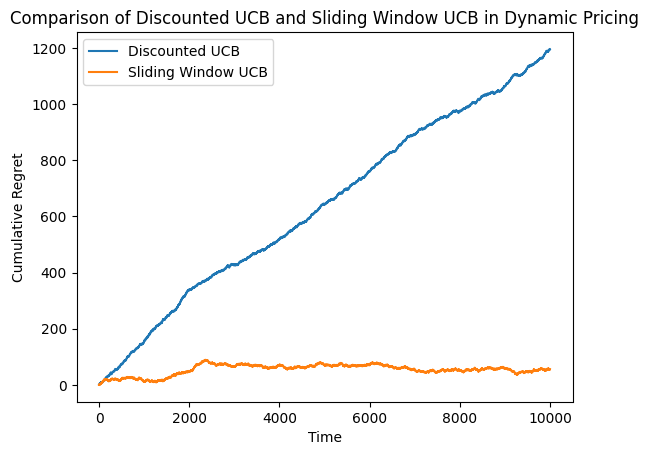

In [ ]:
# Deepseek assignment 1
import numpy as np
import matplotlib.pyplot as plt

class DynamicPricingEnv:
    def __init__(self, prices, change_points, reward_probabilities):
        self.prices = prices
        self.change_points = change_points
        self.reward_probabilities = reward_probabilities
        self.current_phase = 0
        self.t = 0

    def step(self, price_index):
        if self.t in self.change_points:
            self.current_phase = min(self.current_phase + 1, len(self.reward_probabilities) - 1)
        self.t += 1
        return np.random.rand() < self.reward_probabilities[self.current_phase][price_index]

    def reset(self):
        self.current_phase = 0
        self.t = 0

class DiscountedUCB:
    def __init__(self, n_arms, gamma=0.99):
        self.n_arms = n_arms
        self.gamma = gamma
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_arm(self):
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
        total = np.sum(self.counts)
        ucb_values = (self.values / self.counts) + np.sqrt((2 * np.log(total)) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts *= self.gamma
        self.values *= self.gamma
        self.counts[arm] += 1
        self.values[arm] += reward

class SlidingWindowUCB:
    def __init__(self, n_arms, window_size=50):
        self.n_arms = n_arms
        self.window_size = window_size
        self.rewards = [[] for _ in range(n_arms)]

    def select_arm(self):
        for arm in range(self.n_arms):
            if len(self.rewards[arm]) == 0:
                return arm
        total_pulls = sum(len(rewards) for rewards in self.rewards)
        ucb_values = []
        for arm in range(self.n_arms):
            cnt = len(self.rewards[arm])
            avg = sum(self.rewards[arm]) / cnt
            ucb = avg + np.sqrt((2 * np.log(total_pulls)) / cnt)
            ucb_values.append(ucb)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.rewards[arm].append(reward)
        if len(self.rewards[arm]) > self.window_size:
            self.rewards[arm].pop(0)

# Experiment Setup
prices = [5, 10, 15, 20]
change_points = [2000, 4000, 6000, 8000]
reward_probabilities = [
    [0.3, 0.5, 0.2, 0.1],  # Phase 1
    [0.2, 0.6, 0.3, 0.15], # Phase 2
    [0.1, 0.4, 0.5, 0.3],  # Phase 3
    [0.25, 0.35, 0.3, 0.2], # Phase 4
    [0.15, 0.5, 0.25, 0.4]  # Phase 5
]

env = DynamicPricingEnv(prices, change_points, reward_probabilities)
d_ucb = DiscountedUCB(len(prices))
sw_ucb = SlidingWindowUCB(len(prices))

T = 10000  # Total time steps
regrets_d = []
regrets_sw = []

for t in range(T):
    # Discounted UCB
    arm_d = d_ucb.select_arm()
    reward_d = env.step(arm_d)
    d_ucb.update(arm_d, reward_d)
    regrets_d.append(max(reward_probabilities[env.current_phase]) - reward_d)

    # Sliding Window UCB
    arm_sw = sw_ucb.select_arm()
    reward_sw = env.step(arm_sw)
    sw_ucb.update(arm_sw, reward_sw)
    regrets_sw.append(max(reward_probabilities[env.current_phase]) - reward_sw)

# Plot Regrets
plt.plot(np.cumsum(regrets_d), label='Discounted UCB')
plt.plot(np.cumsum(regrets_sw), label='Sliding Window UCB')
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Comparison of Discounted UCB and Sliding Window UCB in Dynamic Pricing")
plt.show()

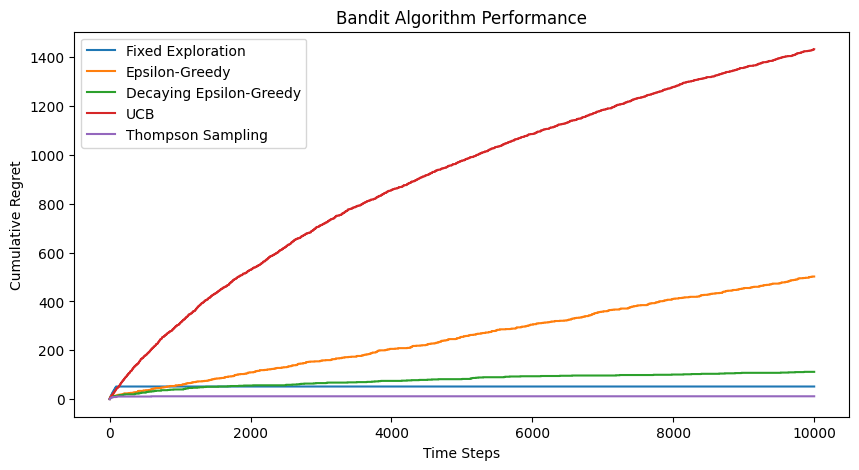

In [62]:
# Deepseek assignment 2
import numpy as np
import matplotlib.pyplot as plt

class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])

class FixedExplorationThenGreedy:
    def __init__(self, num_arms, exploration_steps):
        self.num_arms = num_arms
        self.exploration_steps = exploration_steps
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        if self.t <= self.exploration_steps:
            return (self.t - 1) % self.num_arms
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class EpsilonGreedy:
    def __init__(self, num_arms, epsilon):
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

class EpsilonGreedyDecaying:
    def __init__(self, num_arms, epsilon_schedule):
        self.num_arms = num_arms
        self.epsilon_schedule = epsilon_schedule
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        epsilon = self.epsilon_schedule(self.t)
        if np.random.rand() < epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class ThompsonSampling:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.successes = np.zeros(num_arms)
        self.failures = np.zeros(num_arms)

    def select_arm(self):
        samples = [np.random.beta(self.successes[arm] + 1, self.failures[arm] + 1) for arm in range(self.num_arms)]
        return np.argmax(samples)

    def update(self, arm, reward):
        if reward == 1:
            self.successes[arm] += 1
        else:
            self.failures[arm] += 1

def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []
    optimal_reward = max(env.reward_means)

    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        regret = optimal_reward - reward
        regrets.append(regret)

    return np.cumsum(regrets)

num_arms = 10
reward_means = np.linspace(0, 1, num_arms)
env = BanditEnvironment(num_arms, reward_means)
num_steps = 10000

def epsilon_schedule(t):
    # return 1 / (t + 1)
    return 1 / np.sqrt(t + 1)

plt.figure(figsize=(10,5))

fixed_exploration_regret = run_experiment(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': 100}, env, num_steps)
plt.plot(fixed_exploration_regret, label='Fixed Exploration')

epsilon_greedy_regret = run_experiment(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': 0.1}, env, num_steps)
plt.plot(epsilon_greedy_regret, label='Epsilon-Greedy')

decaying_epsilon_greedy_regret = run_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule}, env, num_steps)
plt.plot(decaying_epsilon_greedy_regret, label='Decaying Epsilon-Greedy')

ucb_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': 4}, env, num_steps)
plt.plot(ucb_regret, label='UCB')

thompson_regret = run_experiment(ThompsonSampling, {'num_arms': num_arms}, env, num_steps)
plt.plot(thompson_regret, label='Thompson Sampling')

plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Bandit Algorithm Performance")
plt.show()

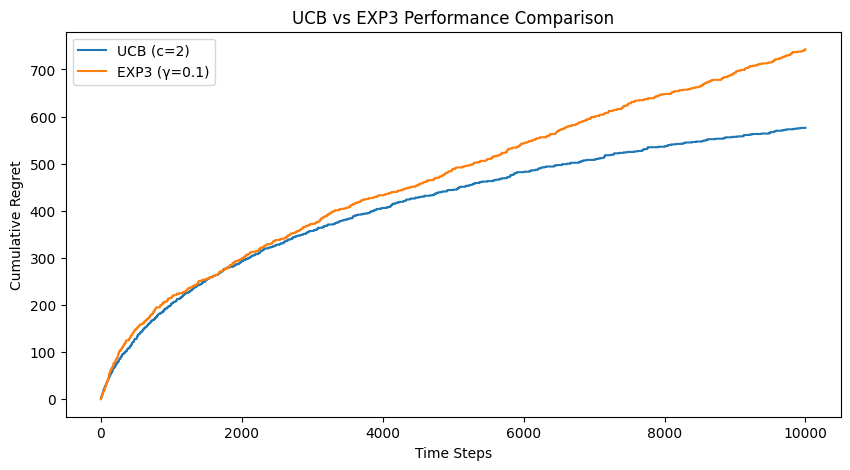

In [73]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])

class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class EXP3:
    def __init__(self, num_arms, gamma):
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        self.t = 1

    def select_arm(self):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)

    def update(self, arm, reward):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)
        self.t += 1

def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []
    optimal_reward = max(env.reward_means)

    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        regret = optimal_reward - reward
        regrets.append(regret)

    return np.cumsum(regrets)

# Experimental setup
num_arms = 10
reward_means = np.linspace(0, 1, num_arms)
env = BanditEnvironment(num_arms, reward_means)
num_steps = 10000

# Run experiments
plt.figure(figsize=(10, 5))

# UCB experiment
ucb_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, env, num_steps)
plt.plot(ucb_regret, label='UCB (c=2)')

# EXP3 experiment
exp3_regret = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, env, num_steps)
plt.plot(exp3_regret, label='EXP3 (γ=0.1)')

plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("UCB vs EXP3 Performance Comparison")
plt.show()

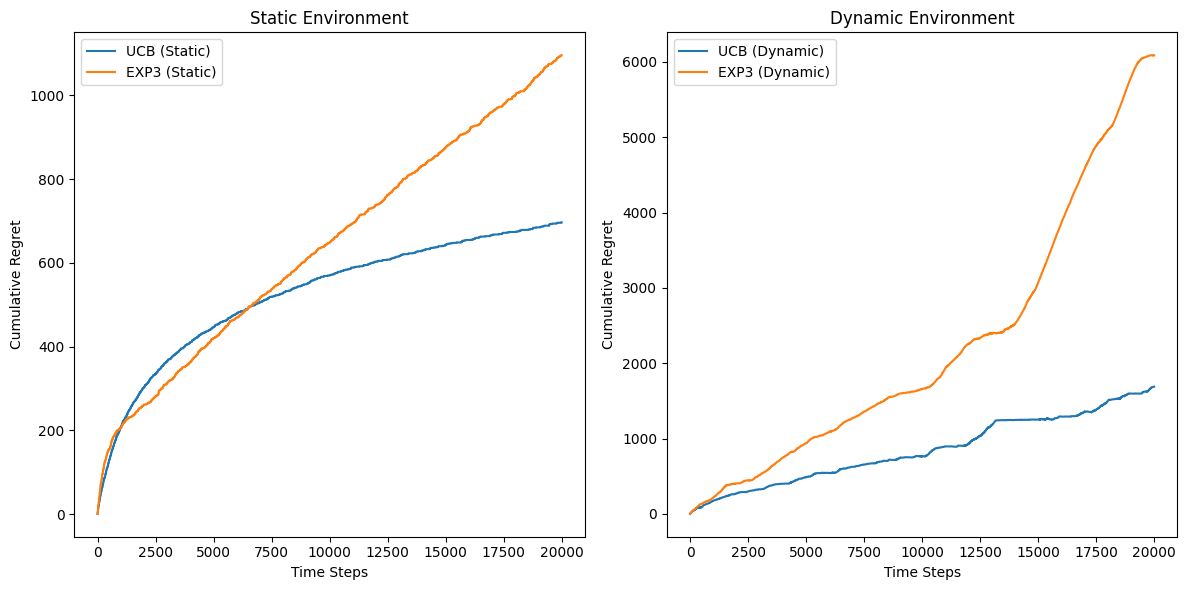

In [136]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])

class DynamicBanditEnvironment(BanditEnvironment):
    def __init__(self, num_arms, reward_means, volatility=0.01):
        super().__init__(num_arms, reward_means)
        self.volatility = volatility

    def pull_arm(self, arm):
        reward = super().pull_arm(arm)  # Get reward first
        # Update means with random walk
        self.reward_means += np.random.normal(0, self.volatility, self.num_arms)
        self.reward_means = np.clip(self.reward_means, 0, 1)
        return reward

class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class EXP3:
    def __init__(self, num_arms, gamma):
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        self.t = 1

    def select_arm(self):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)

    def update(self, arm, reward):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)
        self.t += 1

def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []

    for _ in range(num_steps):
        current_optimal = max(env.reward_means)  # Get current optimal before pull
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        regret = current_optimal - reward
        regrets.append(regret)
        bandit.update(arm, reward)

    return np.cumsum(regrets)

# Experimental setup
num_arms = 10
base_reward_means = np.linspace(0, 1, num_arms)
num_steps = 20000

# Create environments
static_env = BanditEnvironment(num_arms, base_reward_means.copy())
dynamic_env = DynamicBanditEnvironment(num_arms, base_reward_means.copy(), volatility=0.01)

# Run experiments
plt.figure(figsize=(12, 6))

# Static Environment
plt.subplot(1, 2, 1)
ucb_static = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, static_env, num_steps)
exp3_static = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, static_env, num_steps)
plt.plot(ucb_static, label='UCB (Static)')
plt.plot(exp3_static, label='EXP3 (Static)')
plt.title("Static Environment")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

# Dynamic Environment
plt.subplot(1, 2, 2)
ucb_dynamic = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, dynamic_env, num_steps)
exp3_dynamic = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, dynamic_env, num_steps)
plt.plot(ucb_dynamic, label='UCB (Dynamic)')
plt.plot(exp3_dynamic, label='EXP3 (Dynamic)')
plt.title("Dynamic Environment")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.tight_layout()
plt.show()

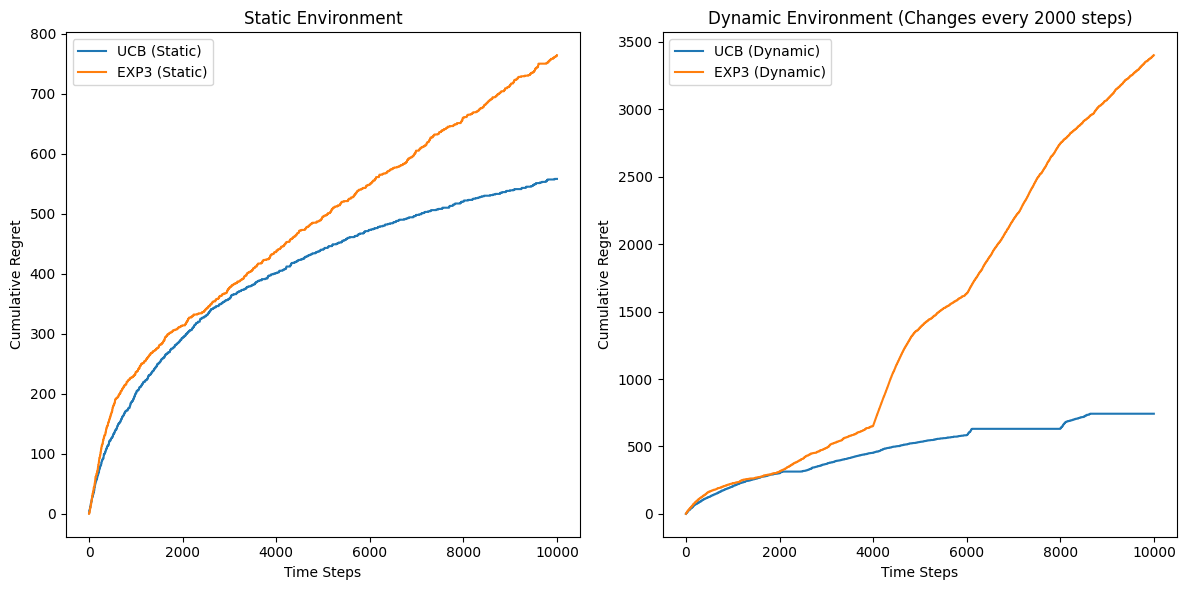

In [140]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])

class DynamicBanditEnvironment(BanditEnvironment):
    def __init__(self, num_arms, reward_means, change_interval=2000):
        super().__init__(num_arms, reward_means.copy())
        self.change_interval = change_interval
        self.time_step = 0
        self.original_means = reward_means.copy()

    def pull_arm(self, arm):
        self.time_step += 1
        if self.time_step % self.change_interval == 0:
            # Shuffle the reward means to abruptly change optimal arm
            np.random.shuffle(self.reward_means)
        return super().pull_arm(arm)

class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class EXP3:
    def __init__(self, num_arms, gamma):
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        self.t = 1

    def select_arm(self):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)

    def update(self, arm, reward):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)
        self.t += 1

def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []

    for _ in range(num_steps):
        current_optimal = max(env.reward_means)
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        regret = current_optimal - reward
        regrets.append(regret)
        bandit.update(arm, reward)

    return np.cumsum(regrets)

# Experimental setup
num_arms = 10
base_reward_means = np.linspace(0, 1, num_arms)
num_steps = 10000

# Create environments
static_env = BanditEnvironment(num_arms, base_reward_means.copy())
dynamic_env = DynamicBanditEnvironment(num_arms, base_reward_means.copy(), change_interval=2000)

# Run experiments
plt.figure(figsize=(12, 6))

# Static Environment
plt.subplot(1, 2, 1)
ucb_static = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, static_env, num_steps)
exp3_static = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, static_env, num_steps)
plt.plot(ucb_static, label='UCB (Static)')
plt.plot(exp3_static, label='EXP3 (Static)')
plt.title("Static Environment")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

# Dynamic Environment
plt.subplot(1, 2, 2)
ucb_dynamic = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, dynamic_env, num_steps)
exp3_dynamic = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, dynamic_env, num_steps)
plt.plot(ucb_dynamic, label='UCB (Dynamic)')
plt.plot(exp3_dynamic, label='EXP3 (Dynamic)')
plt.title("Dynamic Environment (Changes every 2000 steps)")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.tight_layout()
plt.show()

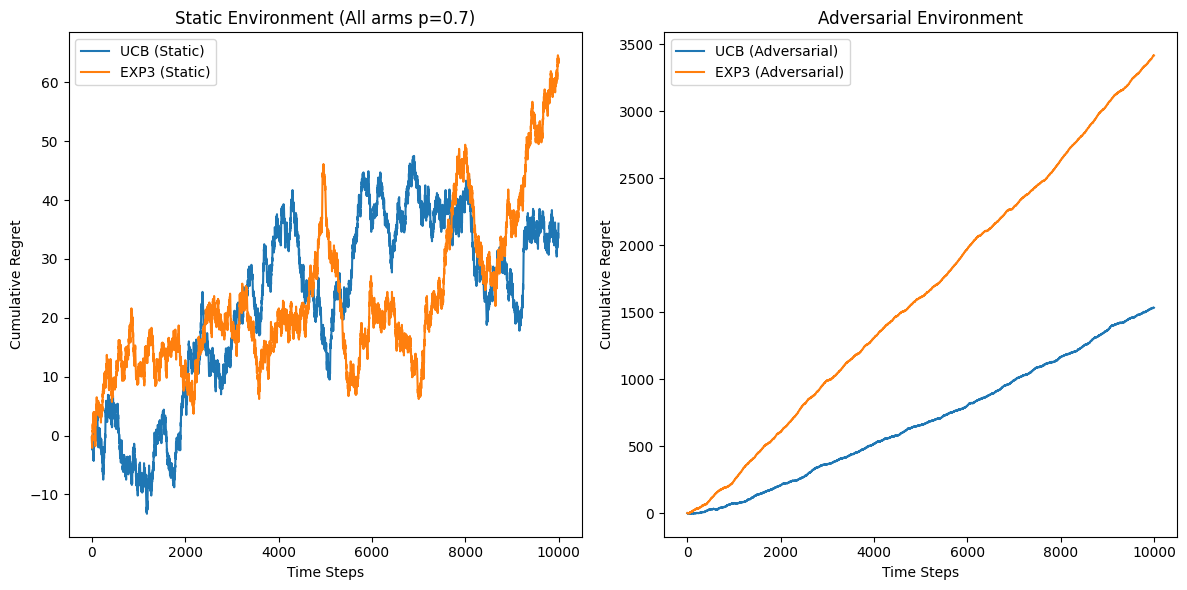

In [141]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])

class AdversarialBanditEnvironment(BanditEnvironment):
    def __init__(self, num_arms, base_reward=0.7, attack_strength=0.02):
        """
        Adversarial environment that actively penalizes successful arms
        Args:
            base_reward: Initial reward probability for all arms
            attack_strength: How much to reduce reward when an arm is pulled
        """
        super().__init__(num_arms, np.full(num_arms, base_reward))
        self.base_reward = base_reward
        self.attack_strength = attack_strength
        self.pull_counts = np.zeros(num_arms)

    def pull_arm(self, arm):
        # Calculate reward before updating probabilities
        reward = super().pull_arm(arm)
        
        # Adversarial update rule:
        self.pull_counts[arm] += 1
        # Reduce reward probability for pulled arm
        self.reward_means[arm] = max(0, self.reward_means[arm] - self.attack_strength)
        # Gradually restore other arms' probabilities toward base reward
        for a in range(self.num_arms):
            if a != arm:
                self.reward_means[a] = min(
                    self.base_reward,
                    self.reward_means[a] + self.attack_strength/(self.num_arms-1)
                )
        return reward

class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class EXP3:
    def __init__(self, num_arms, gamma):
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        self.t = 1

    def select_arm(self):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)

    def update(self, arm, reward):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)
        self.t += 1

def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []

    for _ in range(num_steps):
        current_optimal = max(env.reward_means)
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        regret = current_optimal - reward
        regrets.append(regret)
        bandit.update(arm, reward)

    return np.cumsum(regrets)

# Experimental setup
num_arms = 10
num_steps = 10000

# Create environments
static_env = BanditEnvironment(num_arms, np.full(num_arms, 0.7))
adv_env = AdversarialBanditEnvironment(num_arms, base_reward=0.7, attack_strength=0.02)

# Run experiments
plt.figure(figsize=(12, 6))

# Static Environment
plt.subplot(1, 2, 1)
ucb_static = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, static_env, num_steps)
exp3_static = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, static_env, num_steps)
plt.plot(ucb_static, label='UCB (Static)')
plt.plot(exp3_static, label='EXP3 (Static)')
plt.title("Static Environment (All arms p=0.7)")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

# Adversarial Environment
plt.subplot(1, 2, 2)
ucb_adv = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, adv_env, num_steps)
exp3_adv = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, adv_env, num_steps)
plt.plot(ucb_adv, label='UCB (Adversarial)')
plt.plot(exp3_adv, label='EXP3 (Adversarial)')
plt.title("Adversarial Environment")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\zhang\AppData\Local\Temp\ipykernel_45180\4077046073.py:70: RuntimeWarning: invalid value encountered in divide
  self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
C:\Users\zhang\AppData\Local\Temp\ipykernel_45180\4077046073.py:70: RuntimeWarning: divide by zero encountered in divide
  self.values + self.c * np.sqrt(np.log(self.t) / self.counts)


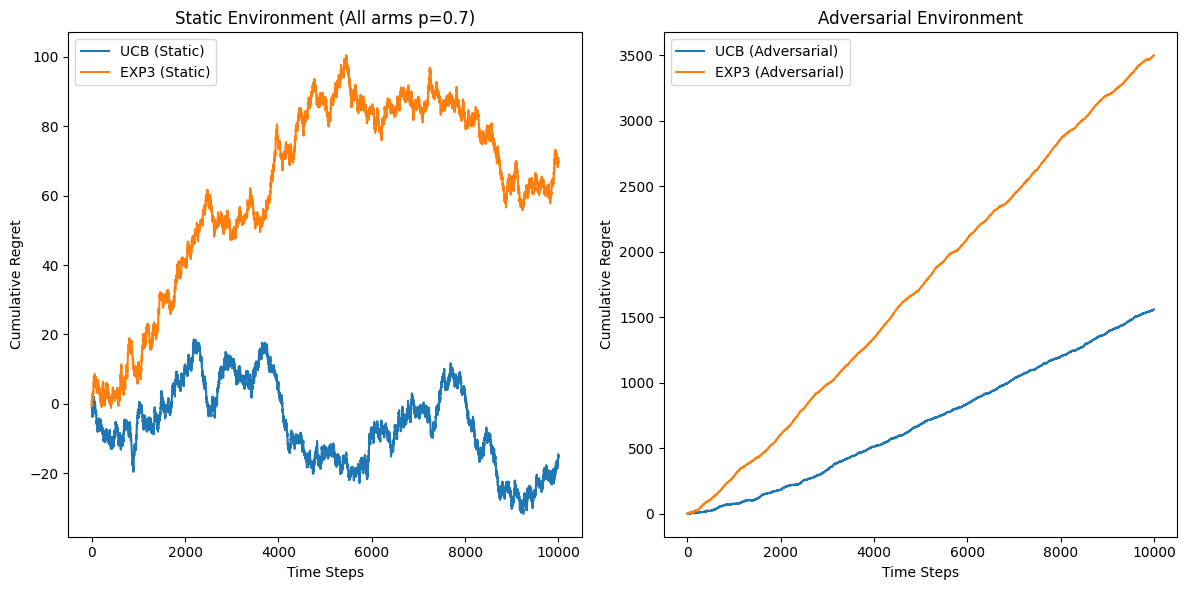

In [142]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        """
        Standard multi-armed bandit environment where each arm has a fixed probability of providing a reward.
        :param num_arms: Number of arms in the bandit environment
        :param reward_means: Array of reward probabilities for each arm
        """
        self.num_arms = num_arms
        self.reward_means = np.array(reward_means)
    
    def pull_arm(self, arm):
        """
        Pulls the specified arm and returns a reward (1 or 0) based on its probability.
        :param arm: The selected arm
        :return: Reward (1 if successful, 0 otherwise)
        """
        return np.random.binomial(1, self.reward_means[arm])

class AdversarialBanditEnvironment(BanditEnvironment):
    def __init__(self, num_arms, base_reward=0.7, attack_strength=0.02):
        """
        Adversarial environment that reduces the reward probability of frequently chosen arms.
        :param num_arms: Number of arms
        :param base_reward: Initial reward probability for all arms
        :param attack_strength: Penalty applied to pulled arms
        """
        super().__init__(num_arms, np.full(num_arms, base_reward))
        self.base_reward = base_reward
        self.attack_strength = attack_strength
        self.pull_counts = np.zeros(num_arms)

    def pull_arm(self, arm):
        reward = super().pull_arm(arm)  # Get reward before modifying probabilities
        self.pull_counts[arm] += 1
        
        # Reduce the reward probability of the pulled arm
        self.reward_means[arm] = max(0, self.reward_means[arm] - self.attack_strength)
        
        # Gradually restore other arms' probabilities toward base reward
        for a in range(self.num_arms):
            if a != arm:
                self.reward_means[a] = min(self.base_reward, self.reward_means[a] + self.attack_strength/(self.num_arms-1))
        
        return reward

class UCB:
    def __init__(self, num_arms, c):
        """
        Upper Confidence Bound (UCB) algorithm for multi-armed bandits.
        :param num_arms: Number of arms
        :param c: Exploration parameter
        """
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)  # Number of times each arm was selected
        self.values = np.zeros(num_arms)  # Estimated values of each arm
        self.t = 1  # Time step

    def select_arm(self):
        """
        Selects the arm using the UCB formula, ensuring unselected arms are picked first.
        :return: Index of the selected arm
        """
        ucb_values = np.where(
            self.counts == 0,  # If arm has never been selected, assign infinity
            np.inf,
            self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        )
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        """
        Updates the estimated value of the selected arm.
        :param arm: The selected arm
        :param reward: The received reward
        """
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class EXP3:
    def __init__(self, num_arms, gamma):
        """
        Exponential-weighted Exploration and Exploitation (EXP3) algorithm.
        :param num_arms: Number of arms
        :param gamma: Exploration parameter
        """
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        self.t = 1

    def select_arm(self):
        """
        Selects an arm based on probability distribution derived from weights.
        :return: Index of the selected arm
        """
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)

    def update(self, arm, reward):
        """
        Updates the weights of the selected arm.
        :param arm: The selected arm
        :param reward: The received reward
        """
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)
        self.weights /= np.sum(self.weights)  # Normalize weights to prevent overflow
        self.t += 1

def run_experiment(bandit_class, bandit_params, env, num_steps):
    """
    Runs the bandit experiment for a given algorithm and environment.
    :param bandit_class: The bandit algorithm class (UCB or EXP3)
    :param bandit_params: Parameters for the bandit algorithm
    :param env: The environment (static or adversarial)
    :param num_steps: Number of time steps
    :return: Cumulative regret over time
    """
    bandit = bandit_class(**bandit_params)
    regrets = []
    
    for _ in range(num_steps):
        current_optimal = max(env.reward_means)
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        regret = current_optimal - reward
        regrets.append(regret)
        bandit.update(arm, reward)
    
    return np.cumsum(regrets)

# Experimental setup
num_arms = 10
num_steps = 10000

# Create environments
static_env = BanditEnvironment(num_arms, np.full(num_arms, 0.7))
adv_env = AdversarialBanditEnvironment(num_arms, base_reward=0.7, attack_strength=0.02)

# Run experiments and plot results
plt.figure(figsize=(12, 6))

# Static Environment
plt.subplot(1, 2, 1)
ucb_static = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, static_env, num_steps)
exp3_static = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, static_env, num_steps)
plt.plot(ucb_static, label='UCB (Static)')
plt.plot(exp3_static, label='EXP3 (Static)')
plt.title("Static Environment (All arms p=0.7)")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

# Adversarial Environment
plt.subplot(1, 2, 2)
ucb_adv = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, adv_env, num_steps)
exp3_adv = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, adv_env, num_steps)
plt.plot(ucb_adv, label='UCB (Adversarial)')
plt.plot(exp3_adv, label='EXP3 (Adversarial)')
plt.title("Adversarial Environment")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.tight_layout()
plt.show()


# Codes below are usless

In [ ]:
# Original assignment 1
import numpy as np
import matplotlib.pyplot as plt

class DynamicPricingEnv:
    def __init__(self, prices, change_points, reward_probabilities):
        self.prices = prices
        self.change_points = change_points
        self.reward_probabilities = reward_probabilities
        self.current_phase = 0
        self.t = 0

    def step(self, price_index):
        if self.t in self.change_points:
            self.current_phase = min(self.current_phase + 1, len(self.reward_probabilities) - 1)
        self.t += 1
        return np.random.rand() < self.reward_probabilities[self.current_phase][price_index]

    def reset(self):
        self.current_phase = 0
        self.t = 0

class DiscountedUCB:
    def __init__(self, n_arms, gamma=0.99):
        self.n_arms = n_arms
        self.gamma = gamma
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_arm(self):
        # TODO: Implement the arm selection logic for Discounted UCB
        return np.random.randint(self.n_arms)  # Temporary fallback to avoid error

    def update(self, arm, reward):
        # TODO: Implement the update rule for Discounted UCB
        pass

class SlidingWindowUCB:
    def __init__(self, n_arms, window_size=50):   # Default window size set to 50
        self.n_arms = n_arms
        self.window_size = window_size
        self.rewards = [[] for _ in range(n_arms)]

    def select_arm(self):
        # TODO: Implement the arm selection logic for Sliding Window UCB
        return np.random.randint(self.n_arms)  # Temporary fallback to avoid error

    def update(self, arm, reward):
        # TODO: Implement update rule for Sliding Window UCB
        pass

# Experiment Setup
prices = [5, 10, 15, 20]
change_points = [2000, 4000, 6000, 8000]
reward_probabilities = [
    [0.3, 0.5, 0.2, 0.1],  # Phase 1
    [0.2, 0.6, 0.3, 0.15], # Phase 2
    [0.1, 0.4, 0.5, 0.3],  # Phase 3
    [0.25, 0.35, 0.3, 0.2], # Phase 4
    [0.15, 0.5, 0.25, 0.4]  # Phase 5
]

env = DynamicPricingEnv(prices, change_points, reward_probabilities)
d_ucb = DiscountedUCB(len(prices))
sw_ucb = SlidingWindowUCB(len(prices))

T = 10000  # Total time steps
regrets_d = []
regrets_sw = []

for t in range(T):
    # Discounted UCB
    arm_d = d_ucb.select_arm()
    reward_d = env.step(arm_d)
    d_ucb.update(arm_d, reward_d)
    regrets_d.append(max(reward_probabilities[env.current_phase]) - reward_d)

    # Sliding Window UCB
    arm_sw = sw_ucb.select_arm()
    reward_sw = env.step(arm_sw)
    sw_ucb.update(arm_sw, reward_sw)
    regrets_sw.append(max(reward_probabilities[env.current_phase]) - reward_sw)

# Plot Regrets
plt.plot(np.cumsum(regrets_d), label='Discounted UCB')
plt.plot(np.cumsum(regrets_sw), label='Sliding Window UCB')
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Comparison of Discounted UCB and Sliding Window UCB in Dynamic Pricing")
plt.show()


In [ ]:
# GPT assignment 1
import numpy as np
import matplotlib.pyplot as plt

class DynamicPricingEnv:
    def __init__(self, prices, change_points, reward_probabilities):
        self.prices = prices
        self.change_points = change_points
        self.reward_probabilities = reward_probabilities
        self.current_phase = 0
        self.t = 0

    def step(self, price_index):
        if self.t in self.change_points:
            self.current_phase = min(self.current_phase + 1, len(self.reward_probabilities) - 1)
        self.t += 1
        return np.random.rand() < self.reward_probabilities[self.current_phase][price_index]

    def reset(self):
        self.current_phase = 0
        self.t = 0

class DiscountedUCB:
    def __init__(self, n_arms, gamma=0.99):
        self.n_arms = n_arms
        self.gamma = gamma
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_arm(self):
        total_counts = np.sum(self.counts)
        if total_counts == 0:
            return np.random.randint(self.n_arms)

        ucb_values = self.values + np.sqrt((2 * np.log(total_counts)) / (self.counts + 1e-6))
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts *= self.gamma
        self.counts[arm] += 1
        self.values[arm] = ((1 - self.gamma) * self.values[arm]) + (self.gamma * reward)

class SlidingWindowUCB:
    def __init__(self, n_arms, window_size=50):
        self.n_arms = n_arms
        self.window_size = window_size
        self.rewards = [[] for _ in range(n_arms)]

    def select_arm(self):
        ucb_values = []
        for i in range(self.n_arms):
            if len(self.rewards[i]) == 0:
                ucb_values.append(float('inf'))
            else:
                mean_reward = np.mean(self.rewards[i])
                confidence = np.sqrt((2 * np.log(sum(len(r) for r in self.rewards) + 1)) / len(self.rewards[i]))
                ucb_values.append(mean_reward + confidence)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.rewards[arm].append(reward)
        if len(self.rewards[arm]) > self.window_size:
            self.rewards[arm].pop(0)

# Experiment Setup
prices = [5, 10, 15, 20]
change_points = [2000, 4000, 6000, 8000]
reward_probabilities = [
    [0.3, 0.5, 0.2, 0.1],  # Phase 1
    [0.2, 0.6, 0.3, 0.15], # Phase 2
    [0.1, 0.4, 0.5, 0.3],  # Phase 3
    [0.25, 0.35, 0.3, 0.2], # Phase 4
    [0.15, 0.5, 0.25, 0.4]  # Phase 5
]

env = DynamicPricingEnv(prices, change_points, reward_probabilities)
d_ucb = DiscountedUCB(len(prices))
sw_ucb = SlidingWindowUCB(len(prices))

T = 10000  # Total time steps
regrets_d = []
regrets_sw = []

for t in range(T):
    # Discounted UCB
    arm_d = d_ucb.select_arm()
    reward_d = env.step(arm_d)
    d_ucb.update(arm_d, reward_d)
    regrets_d.append(max(reward_probabilities[env.current_phase]) - reward_d)

    # Sliding Window UCB
    arm_sw = sw_ucb.select_arm()
    reward_sw = env.step(arm_sw)
    sw_ucb.update(arm_sw, reward_sw)
    regrets_sw.append(max(reward_probabilities[env.current_phase]) - reward_sw)

# Plot Regrets
plt.plot(np.cumsum(regrets_d), label='Discounted UCB')
plt.plot(np.cumsum(regrets_sw), label='Sliding Window UCB')
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Comparison of Discounted UCB and Sliding Window UCB in Dynamic Pricing")
plt.show()


In [ ]:
# Original assignment 2
import numpy as np
import matplotlib.pyplot as plt

# Bandit Environment
class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])  # Bernoulli rewards

# ==========================
# Fixed Exploration Then Exploitation (TODO: Implement switching strategy)
# ==========================
class FixedExplorationThenGreedy:
    def __init__(self, num_arms, exploration_steps):
        self.num_arms = num_arms
        self.exploration_steps = exploration_steps
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        """ TODO: Implement fixed exploration for N steps, then greedy """
        pass

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Epsilon-Greedy Algorithm (TODO: Complete update function)
# ==========================
class EpsilonGreedy:
    def __init__(self, num_arms, epsilon):
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)

    def select_arm(self):
        """ TODO: Implement selection rule """
        pass

    def update(self, arm, reward):
        """ TODO: Implement incremental mean update """
        pass

# ==========================
# Epsilon-Greedy with Decaying Exploration (TODO: Complete decay schedule and compare schedules)
# ==========================
class EpsilonGreedyDecaying:
    def __init__(self, num_arms, epsilon_schedule):
        self.num_arms = num_arms
        self.epsilon_schedule = epsilon_schedule  # Function for epsilon_t
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        """ TODO: Implement selection rule """
        pass

    def update(self, arm, reward):
        """ TODO: Implement update rule including epsilon decay """
        pass

# ==========================
# UCB Algorithm (TODO: Complete selection function)
# ==========================
class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        """ TODO: Implement UCB selection rule """
        pass

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Thompson Sampling Algorithm (TODO: Implement Thompson Sampling)
# ==========================
class ThompsonSampling:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.successes = np.zeros(num_arms)
        self.failures = np.zeros(num_arms)

    def select_arm(self):
        """ TODO: Implement Thompson Sampling selection rule """
        pass

    def update(self, arm, reward):
        """ TODO: Implement update rule for Beta distribution """
        pass

# ==========================
# Experiment Runner
# ==========================
def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []
    optimal_reward = max(env.reward_means)

    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        regret = optimal_reward - reward
        regrets.append(regret)

    return np.cumsum(regrets)

# ==========================
# Running Experiments
# ==========================
num_arms = 10
reward_means = np.linspace(0, 1, num_arms)  # Linearly spaced rewards
env = BanditEnvironment(num_arms, reward_means)
num_steps = 10000

# Define epsilon schedule
def epsilon_schedule(t):
    return 1 / (t + 1)

# Plot setup
plt.figure(figsize=(10,5))

# Run and plot Fixed Exploration Then Exploitation
fixed_exploration_regret = run_experiment(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': 100}, env, num_steps)
plt.plot(fixed_exploration_regret, label='Fixed Exploration')

# Run and plot ε-Greedy
epsilon_greedy_regret = run_experiment(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': 0.1}, env, num_steps)
plt.plot(epsilon_greedy_regret, label='Epsilon-Greedy')

# Run and plot Decaying ε-Greedy
decaying_epsilon_greedy_regret = run_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule}, env, num_steps)
plt.plot(decaying_epsilon_greedy_regret, label='Decaying Epsilon-Greedy')

# Run and plot UCB
ucb_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': 4}, env, num_steps)
plt.plot(ucb_regret, label='UCB')

# Run and plot Thompson Sampling
thompson_regret = run_experiment(ThompsonSampling, {'num_arms': num_arms}, env, num_steps)
plt.plot(thompson_regret, label='Thompson Sampling')

plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Bandit Algorithm Performance")
plt.show()

# ==========================
# Instructions for Students
# ==========================
print("TODO: Complete the missing functions for Fixed-Exploration-Greedy, Epsilon-Greedy, Decaying Epsilon-Greedy, UCB, and Thompson Sampling.")
print("TODO: Implement and compare different epsilon schedules (e.g., 1/t, 1/sqrt(t), log(t)/t). Discuss the impact on exploration and cumulative regret in your report.")
print("TODO: Answer the questions in the assignment and conduct the necessary experiments to answer them.")


In [ ]:
# GPT assignment 2
import numpy as np
import matplotlib.pyplot as plt

# Bandit Environment
class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])  # Bernoulli rewards

# ==========================
# Fixed Exploration Then Exploitation (TODO: Implement switching strategy)
# ==========================
class FixedExplorationThenGreedy:
    def __init__(self, num_arms, exploration_steps):
        self.num_arms = num_arms
        self.exploration_steps = exploration_steps
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        """ TODO: Implement fixed exploration for N steps, then greedy """
        if self.t <= self.exploration_steps:
            return np.random.randint(self.num_arms)  # Random exploration
        return np.argmax(self.values)  # Greedy exploitation

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Epsilon-Greedy Algorithm (TODO: Complete update function)
# ==========================
class EpsilonGreedy:
    def __init__(self, num_arms, epsilon):
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)

    def select_arm(self):
        """ TODO: Implement selection rule """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_arms)  # Explore
        return np.argmax(self.values)  # Exploit

    def update(self, arm, reward):
        """ TODO: Implement incremental mean update """
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

# ==========================
# Epsilon-Greedy with Decaying Exploration (TODO: Complete decay schedule and compare schedules)
# ==========================
class EpsilonGreedyDecaying:
    def __init__(self, num_arms, epsilon_schedule):
        self.num_arms = num_arms
        self.epsilon_schedule = epsilon_schedule  # Function for epsilon_t
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        """ TODO: Implement selection rule """
        epsilon_t = self.epsilon_schedule(self.t)
        if np.random.rand() < epsilon_t:
            return np.random.randint(self.num_arms)  # Explore
        return np.argmax(self.values)  # Exploit

    def update(self, arm, reward):
        """ TODO: Implement update rule including epsilon decay """
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# UCB Algorithm (TODO: Complete selection function)
# ==========================
class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        """ Implement UCB selection rule """
        total_counts = np.sum(self.counts)
        if total_counts < self.num_arms:  # Ensure each arm is tried at least once
            return int(total_counts)  # Explicitly cast to integer
        ucb_values = self.values + self.c * np.sqrt(np.log(total_counts) / (self.counts + 1e-6))
        return int(np.argmax(ucb_values))  # Ensure output is an integer


    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Thompson Sampling Algorithm (TODO: Implement Thompson Sampling)
# ==========================
class ThompsonSampling:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.successes = np.zeros(num_arms)
        self.failures = np.zeros(num_arms)

    def select_arm(self):
        """ TODO: Implement Thompson Sampling selection rule """
        samples = [np.random.beta(self.successes[i] + 1, self.failures[i] + 1) for i in range(self.num_arms)]
        return np.argmax(samples)

    def update(self, arm, reward):
        """ TODO: Implement update rule for Beta distribution """
        if reward == 1:
            self.successes[arm] += 1
        else:
            self.failures[arm] += 1

# ==========================
# Experiment Runner
# ==========================
def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []
    optimal_reward = max(env.reward_means)

    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        regret = optimal_reward - reward
        regrets.append(regret)

    return np.cumsum(regrets)

# ==========================
# Running Experiments
# ==========================
num_arms = 10
reward_means = np.linspace(0, 1, num_arms)  # Linearly spaced rewards
env = BanditEnvironment(num_arms, reward_means)
num_steps = 10000

# Define epsilon schedule
def epsilon_schedule(t):
    return 1 / (t + 1)

# Plot setup
plt.figure(figsize=(10,5))

# Run and plot Fixed Exploration Then Exploitation
fixed_exploration_regret = run_experiment(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': 100}, env, num_steps)
plt.plot(fixed_exploration_regret, label='Fixed Exploration')

# Run and plot ε-Greedy
epsilon_greedy_regret = run_experiment(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': 0.1}, env, num_steps)
plt.plot(epsilon_greedy_regret, label='Epsilon-Greedy')

# Run and plot Decaying ε-Greedy
decaying_epsilon_greedy_regret = run_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule}, env, num_steps)
plt.plot(decaying_epsilon_greedy_regret, label='Decaying Epsilon-Greedy')

# Run and plot UCB
ucb_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': 4}, env, num_steps)
plt.plot(ucb_regret, label='UCB')

# Run and plot Thompson Sampling
thompson_regret = run_experiment(ThompsonSampling, {'num_arms': num_arms}, env, num_steps)
plt.plot(thompson_regret, label='Thompson Sampling')

plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Bandit Algorithm Performance")
plt.show()

# ==========================
# Instructions for Students
# ==========================
print("TODO: Complete the missing functions for Fixed-Exploration-Greedy, Epsilon-Greedy, Decaying Epsilon-Greedy, UCB, and Thompson Sampling.")
print("TODO: Implement and compare different epsilon schedules (e.g., 1/t, 1/sqrt(t), log(t)/t). Discuss the impact on exploration and cumulative regret in your report.")
print("TODO: Answer the questions in the assignment and conduct the necessary experiments to answer them.")


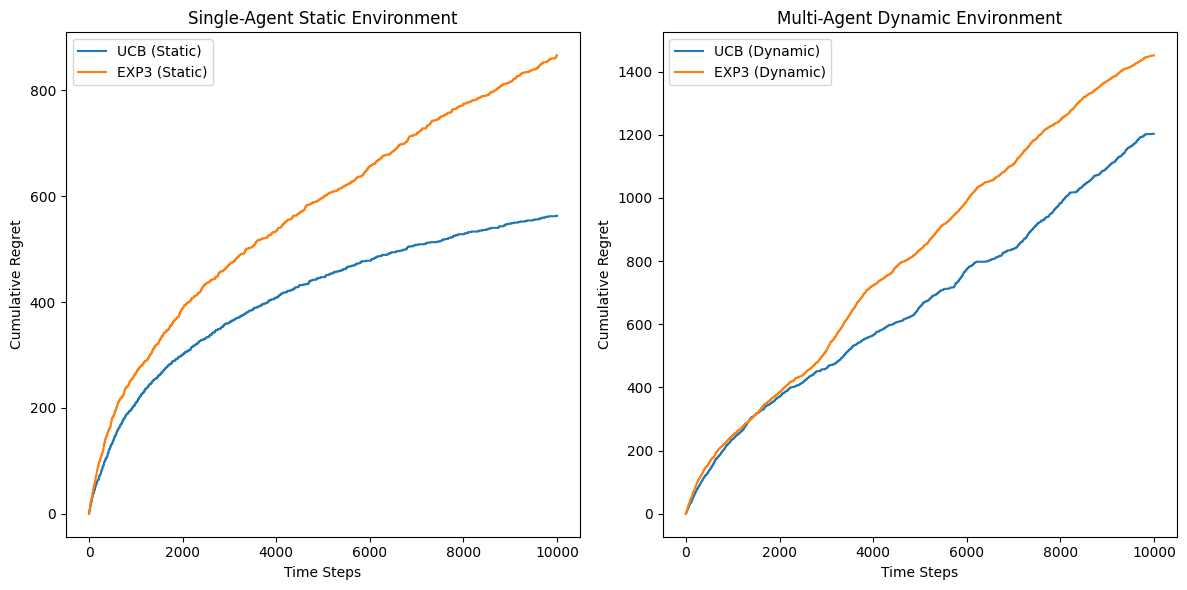

In [118]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])

class DynamicBanditEnvironment(BanditEnvironment):
    def __init__(self, num_arms, reward_means, volatility=0.001):
        super().__init__(num_arms, reward_means)
        self.volatility = volatility
        self.original_means = reward_means.copy()
        
    def pull_arm(self, arm):
        # Simulate dynamic environment with mean reversion
        self.reward_means += np.random.normal(0, self.volatility, self.num_arms)
        self.reward_means = np.clip(self.reward_means, 0, 1)
        return np.random.binomial(1, self.reward_means[arm])

class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        #for arm in range(self.num_arms):
        #    if self.counts[arm] == 0:
        #        return arm

        if np.any(self.counts == 0):  # Ensure each arm is picked once
            untried_arms = np.where(self.counts == 0)[0]
            return np.random.choice(untried_arms)  # Randomize initial selections

        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class EXP3:
    def __init__(self, num_arms, gamma):
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        self.t = 1

    def select_arm(self):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)

    def update(self, arm, reward):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)
        self.t += 1

def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []
    optimal_reward = max(env.reward_means if isinstance(env, BanditEnvironment) else env.original_means)

    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)

        regret = optimal_reward - reward
        regrets.append(regret)

    return np.cumsum(regrets)

def run_multi_agent_experiment(bandit_classes, bandit_params_list, env, num_steps):
    bandits = [cls(**params) for cls, params in zip(bandit_classes, bandit_params_list)]
    regrets = {i: [] for i in range(len(bandits))}
    optimal_reward = max(env.original_means)

    for t in range(num_steps):
        for i, bandit in enumerate(bandits):
            arm = bandit.select_arm()
            reward = env.pull_arm(arm)
            bandit.update(arm, reward)
            regret = optimal_reward - reward
            regrets[i].append(regret)

    return {k: np.cumsum(v) for k, v in regrets.items()}

# Experimental setup
num_arms = 10
base_reward_means = np.linspace(0, 1, num_arms)
num_steps = 10000

# Single-Agent Static Environment
static_env = BanditEnvironment(num_arms, base_reward_means.copy())

# Multi-Agent Dynamic Environment
dynamic_env = DynamicBanditEnvironment(num_arms, base_reward_means.copy(), volatility=0.002)

# Run experiments
plt.figure(figsize=(12, 6))

# Single-Agent Experiments
plt.subplot(1, 2, 1)
ucb_static_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': 2}, static_env, num_steps)
exp3_static_regret = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, static_env, num_steps)

plt.plot(ucb_static_regret, label='UCB (Static)')
plt.plot(exp3_static_regret, label='EXP3 (Static)')
plt.title("Single-Agent Static Environment")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()


# Multi-Agent Dynamic Environment
plt.subplot(1, 2, 2)
dynamic_results = run_multi_agent_experiment(
    [UCB, EXP3, UCB, EXP3],
    [{'num_arms': num_arms, 'c': 2},
     {'num_arms': num_arms, 'gamma': 0.1},
     {'num_arms': num_arms, 'c': 2},
     {'num_arms': num_arms, 'gamma': 0.1}],
    dynamic_env,
    num_steps
)

# Average results for each algorithm type
ucb_dynamic_regret = (dynamic_results[0] + dynamic_results[2]) / 2
exp3_dynamic_regret = (dynamic_results[1] + dynamic_results[3]) / 2

plt.plot(ucb_dynamic_regret, label='UCB (Dynamic)')
plt.plot(exp3_dynamic_regret, label='EXP3 (Dynamic)')
plt.title("Multi-Agent Dynamic Environment")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.tight_layout()
plt.show()

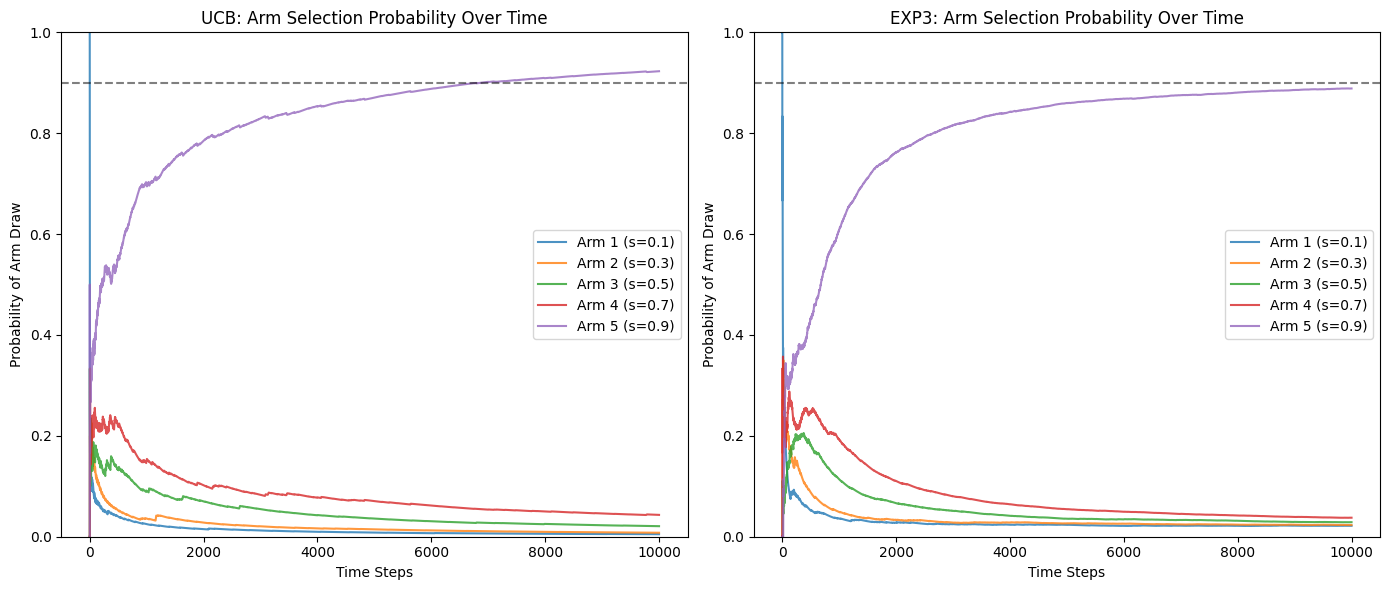

In [114]:
import numpy as np
import matplotlib.pyplot as plt

class TrackingBanditEnvironment(BanditEnvironment):
    def __init__(self, num_arms, reward_means):
        super().__init__(num_arms, reward_means)
        self.optimal_arm = np.argmax(reward_means)
        
# Modified experiment function to track arm probabilities
def run_tracking_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    arm_selections = np.zeros((num_steps, env.num_arms))
    
    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        arm_selections[t, arm] = 1
    
    # Calculate cumulative probabilities
    cumulative_counts = np.cumsum(arm_selections, axis=0)
    total_counts = np.arange(1, num_steps+1)[:, np.newaxis]
    return cumulative_counts / total_counts

# Set up environment with clear optimal arm (mirroring paper's s values)
num_arms = 5
reward_means = np.array([0.1, 0.3, 0.5, 0.7, 0.9])  # Explicit s values (spreads)
static_env = TrackingBanditEnvironment(num_arms, reward_means)
num_steps = 10000

# Run tracking experiments
ucb_probs = run_tracking_experiment(UCB, {'num_arms': num_arms, 'c': 2}, static_env, num_steps)
exp3_probs = run_tracking_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, static_env, num_steps)

# Plot results
plt.figure(figsize=(14, 6))

# UCB Arm Selection Probabilities
plt.subplot(1, 2, 1)
for arm in range(num_arms):
    plt.plot(ucb_probs[:, arm], label=f'Arm {arm+1} (s={reward_means[arm]:.1f})', alpha=0.8)
plt.axhline(y=0.9, color='black', linestyle='--', alpha=0.5)
plt.title('UCB: Arm Selection Probability Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Probability of Arm Draw')
plt.legend()
plt.ylim(0, 1)

# EXP3 Arm Selection Probabilities
plt.subplot(1, 2, 2)
for arm in range(num_arms):
    plt.plot(exp3_probs[:, arm], label=f'Arm {arm+1} (s={reward_means[arm]:.1f})', alpha=0.8)
plt.axhline(y=0.9, color='black', linestyle='--', alpha=0.5)
plt.title('EXP3: Arm Selection Probability Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Probability of Arm Draw')
plt.legend()
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

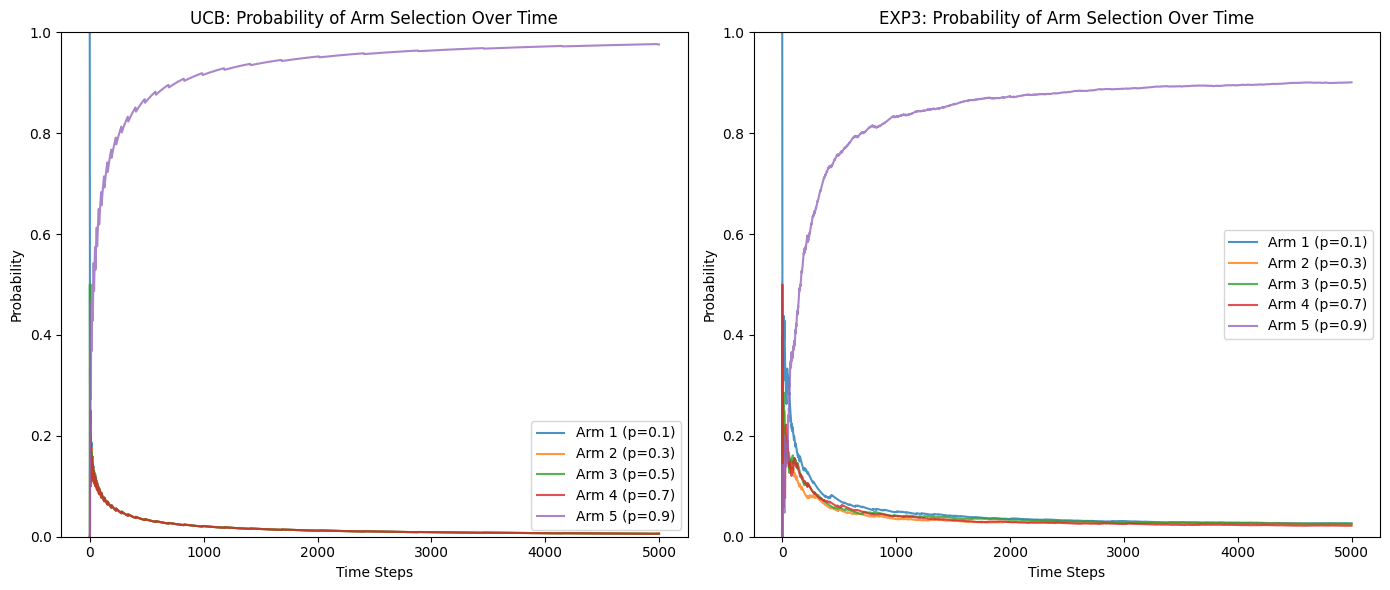

In [128]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])

class FixedCompetitorEnvironment(BanditEnvironment):
    def __init__(self, num_arms, reward_means, competitor_arm):
        super().__init__(num_arms, reward_means)
        self.competitor_arm = competitor_arm
        self.competitor_value = reward_means[competitor_arm]
        
    def pull_arm(self, arm):
        # Reward is probability of winning against competitor
        return np.random.binomial(1, self.reward_means[arm] > self.competitor_value)

class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        if np.any(self.counts == 0):
            return np.random.choice(np.where(self.counts == 0)[0])
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / (self.counts + 1e-6))
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

class EXP3:
    def __init__(self, num_arms, gamma):
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        
    def select_arm(self):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)

    def update(self, arm, reward):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)


def run_tracking_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    arm_selections = np.zeros((num_steps, env.num_arms))
    
    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        arm_selections[t, arm] = 1
    
    return np.cumsum(arm_selections, axis=0) / np.arange(1, num_steps+1)[:, np.newaxis]

# Experimental setup
num_arms = 5
reward_means = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
competitor_arm = 3  # Competitor selects arm index 3 (s = 0.3)
num_steps = 5000

# Create environment with fixed competitor
env = FixedCompetitorEnvironment(num_arms, reward_means, competitor_arm)

# Run experiments
ucb_probs = run_tracking_experiment(UCB, {'num_arms': num_arms, 'c': 2}, env, num_steps)
exp3_probs = run_tracking_experiment(EXP3, {'num_arms': num_arms, 'gamma': 0.1}, env, num_steps)

# Plot results
plt.figure(figsize=(14, 6))

# UCB Arm Selection Probabilities
plt.subplot(1, 2, 1)
for arm in range(num_arms):
    plt.plot(ucb_probs[:, arm], label=f'Arm {arm+1} (p={reward_means[arm]:.1f})', alpha=0.8)
plt.title('UCB: Probability of Arm Selection Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Probability')
plt.legend()
plt.ylim(0, 1)

# EXP3 Arm Selection Probabilities
plt.subplot(1, 2, 2)
for arm in range(num_arms):
    plt.plot(exp3_probs[:, arm], label=f'Arm {arm+1} (p={reward_means[arm]:.1f})', alpha=0.8)
plt.title('EXP3: Probability of Arm Selection Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Probability')
plt.legend()
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


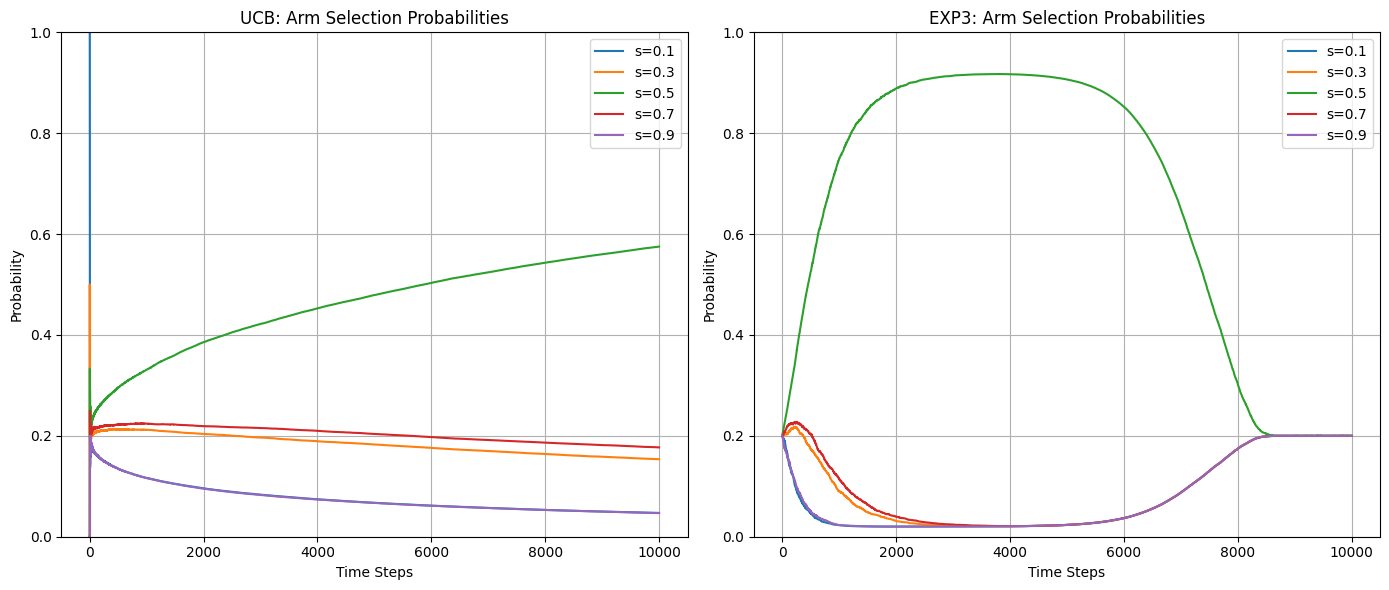

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

class CompetitiveBanditEnvironment:
    def __init__(self, spreads, competitor_spread, s_T=1.0, ω=0.15, ρ=0.5):
        """
        Parameters from paper:
        - s_T: Trader's reservation spread
        - ω: Measurement error standard deviation
        - ρ: Correlation between LPs' measurement errors
        """
        self.spreads = spreads
        self.competitor_spread = competitor_spread
        self.s_T = s_T
        self.ω = ω
        self.ρ = ρ
        
        # Precompute terms from paper's equation (11)
        self.ω_T = ω * np.sqrt(ρ + (1-ρ)/2)  # For N=2 competitors
        
    def get_win_probability(self, s_i):
        """Calculate probability of winning against competitor (equation 11)"""
        # Simplified version of the paper's integral formulation
        # Using probit approximation for the cumulative normal
        z = (self.s_T - s_i) / (2 * self.ω_T)
        return norm.cdf(z) * norm.cdf((self.competitor_spread - s_i)/(2*self.ω*np.sqrt(1-self.ρ)))
    
    def get_reward(self, arm):
        """Full reward calculation from paper's equation (7)"""
        s_i = self.spreads[arm]
        win_prob = self.get_win_probability(s_i)
        
        # Expected reward components
        spread_reward = s_i/2 * win_prob
        adverse_selection = -self.ω * np.sqrt(1-self.ρ) * (1/np.sqrt(2*np.pi))  # Simplified μ_i^(1)
        
        # Add noise for exploration
        noise = np.random.normal(0, 0.05)
        return spread_reward + adverse_selection + noise

class UCB:
    def __init__(self, n_arms, c=1.5):
        self.n_arms = n_arms
        self.c = c
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.total_counts = 0
        
    def select_arm(self):
        if self.total_counts < self.n_arms:
            return self.total_counts  # Initial exploration
        
        ucb = self.values + self.c * np.sqrt(np.log(self.total_counts)/(self.counts + 1e-6))
        return np.argmax(ucb)
    
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.total_counts += 1
        self.values[arm] += (reward - self.values[arm])/self.counts[arm]

class EXP3:
    def __init__(self, n_arms, gamma=0.1):
        self.n_arms = n_arms
        self.gamma = gamma
        self.weights = np.ones(n_arms)
        self.probabilities = np.ones(n_arms)/n_arms
        
    def select_arm(self):
        self.probabilities = (1-self.gamma)*self.weights/self.weights.sum() + self.gamma/self.n_arms
        return np.random.choice(self.n_arms, p=self.probabilities)
    
    def update(self, arm, reward):
        # Normalize reward to [-1,1] for stability
        normalized_reward = (reward - 0.2) / 0.5  # Based on observed reward range
        estimated_reward = normalized_reward / self.probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward/self.n_arms)
        self.weights = np.clip(self.weights, 1e-6, 1e6)

# Experimental setup
spreads = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
competitor_spread = 0.7
env = CompetitiveBanditEnvironment(spreads=spreads,
                                  competitor_spread=competitor_spread,
                                  s_T=1.0,
                                  ω=0.15,
                                  ρ=0.5)

# Run experiments
n_steps = 10000
n_runs = 20

def run_experiment(algorithm, env):
    history = np.zeros((n_steps, len(spreads)))
    for t in range(n_steps):
        arm = algorithm.select_arm()
        reward = env.get_reward(arm)
        algorithm.update(arm, reward)
        
        # Track empirical probabilities
        if isinstance(algorithm, UCB):
            probs = algorithm.counts / (algorithm.total_counts + 1e-6)
        else:
            probs = algorithm.probabilities
        history[t] = probs
    return history

# Aggregate results
ucb_probs = np.zeros((n_steps, len(spreads)))
exp3_probs = np.zeros((n_steps, len(spreads)))

for _ in range(n_runs):
    ucb = UCB(n_arms=len(spreads))
    exp3 = EXP3(n_arms=len(spreads))
    
    ucb_probs += run_experiment(ucb, env)
    exp3_probs += run_experiment(exp3, env)

ucb_probs /= n_runs
exp3_probs /= n_runs

# Plot results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, s in enumerate(spreads):
    plt.plot(ucb_probs[:, i], label=f's={s:.1f}')
plt.title('UCB: Arm Selection Probabilities')
plt.xlabel('Time Steps')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
for i, s in enumerate(spreads):
    plt.plot(exp3_probs[:, i], label=f's={s:.1f}')
plt.title('EXP3: Arm Selection Probabilities')
plt.xlabel('Time Steps')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()